<a href="https://colab.research.google.com/github/misiek98/cv/blob/master/08_Maski/03_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# **ZAŁADOWANIE MODELU**

In [4]:
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))])

# **ZAŁADOWANIE ETYKIET**

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

24576/10484 [======================================================================] - 0s 0us/step


array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [8]:
from google.colab import files
uploaded = files.upload()

Saving img4.png to img4.png


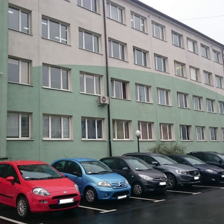

In [10]:
filename = list(uploaded.keys())[0]
img = Image.open(filename).resize(IMAGE_SHAPE)
img

In [11]:
img_arr = np.array(img) / 255.
img_arr = np.expand_dims(img_arr, axis=0)
result = classifier.predict(img_arr)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name

'convertible'

# **TRANSFER LEARNING**

In [12]:
%%bash
wget -q https://storage.googleapis.com/esmartdata-courses-files/opencv-python/images.zip
unzip -q images.zip

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
image_data = image_generator.flow_from_directory('images', target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
  print('Image batch shape', image_batch.shape)
  print('Label batch shape', label_batch.shape)
  break

result_batch = classifier.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

Found 1113 images belonging to 2 classes.
Image batch shape (32, 224, 224, 3)
Label batch shape (32, 2)


array(['triceratops', 'sorrel', 'lion', 'lion', 'sorrel',
       'standard poodle', 'lion', 'shield', 'sorrel', 'teddy',
       'water buffalo', 'sorrel', 'sorrel', 'ram', 'warthog', 'lion',
       'sorrel', 'orangutan', 'Ibizan hound', 'lion', 'Mexican hairless',
       'bison', 'lion', 'horse cart', 'lynx', 'chow', 'sloth bear',
       'lion', 'muzzle', 'lion', 'sorrel', 'cowboy boot'], dtype='<U30')

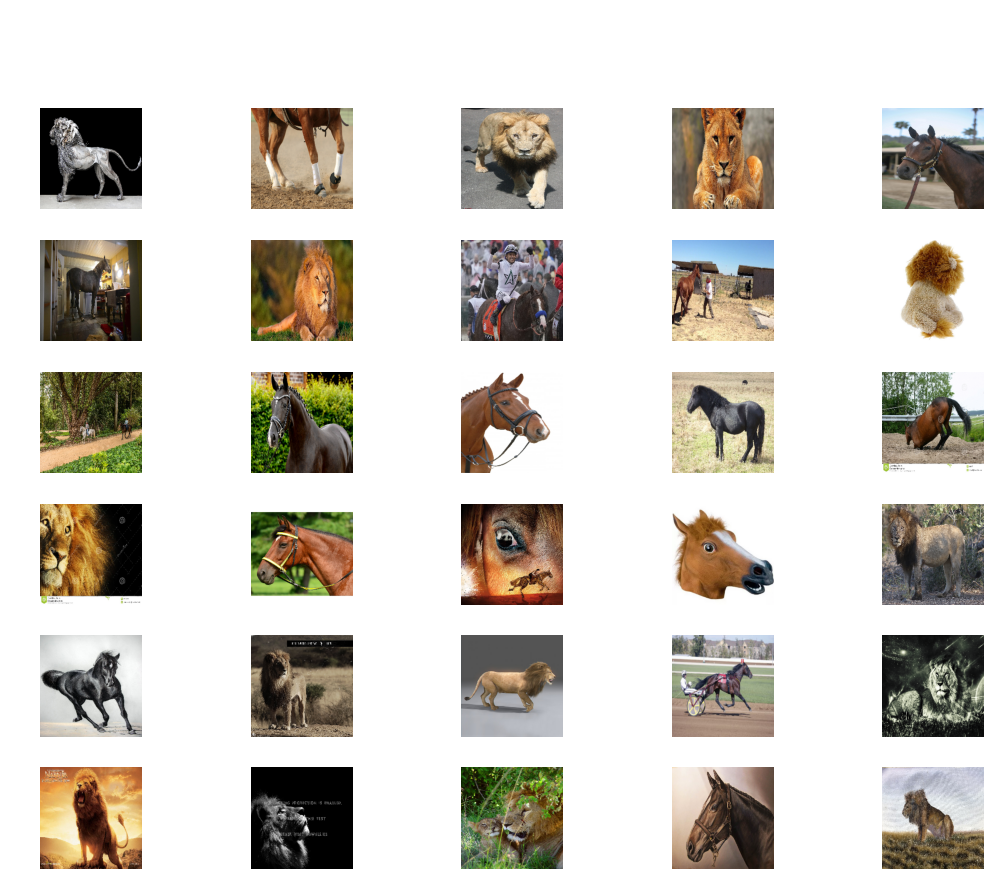

In [18]:
plt.figure(figsize=(18, 14))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n], color='white', fontdict={'fontsize': 20})
  plt.axis('off')
  plt.suptitle('ImageNet predictions', color='white', fontsize=20)

# **EKSTRAKTOR CECH**

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=IMAGE_SHAPE+(3,)
)

# zamrażamy wagi ekstraktora
feature_extractor_layer.trainable = False

# budujemy model dokładając ostatnią warstwę klasyfikacji
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
# zbudujemy niestandardowy Callback aby rejestrować stratę (loss) i dokładność (accuracy) po każdym wsadzie (batch)
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [21]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=3,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
35/35 [==============================] - 79s 2s/step - loss: 0.1355 - acc: 0.9688
Epoch 2/3
35/35 [==============================] - 75s 2s/step - loss: 0.2816 - acc: 0.8750
Epoch 3/3
35/35 [==============================] - 78s 2s/step - loss: 0.0547 - acc: 0.9688


In [24]:
import pandas as pd
import plotly.graph_objects as go

def plot_hist(batch_stats_callback):
    hist = pd.DataFrame({'loss': batch_stats_callback.batch_losses,
                         'accuracy': batch_stats_callback.batch_acc})
    hist['batch'] = hist.index
    hist['batch'] += 1  

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['batch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.update_layout(width=800, height=400, title='accuracy', xaxis_title='batches', yaxis_title='accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['batch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.update_layout(width=800, height=400, title='loss', xaxis_title='batches', yaxis_title='loss', yaxis_type='log')
    fig.show()

plot_hist(batch_stats_callback)

In [25]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Horse', 'Lion'], dtype='<U5')

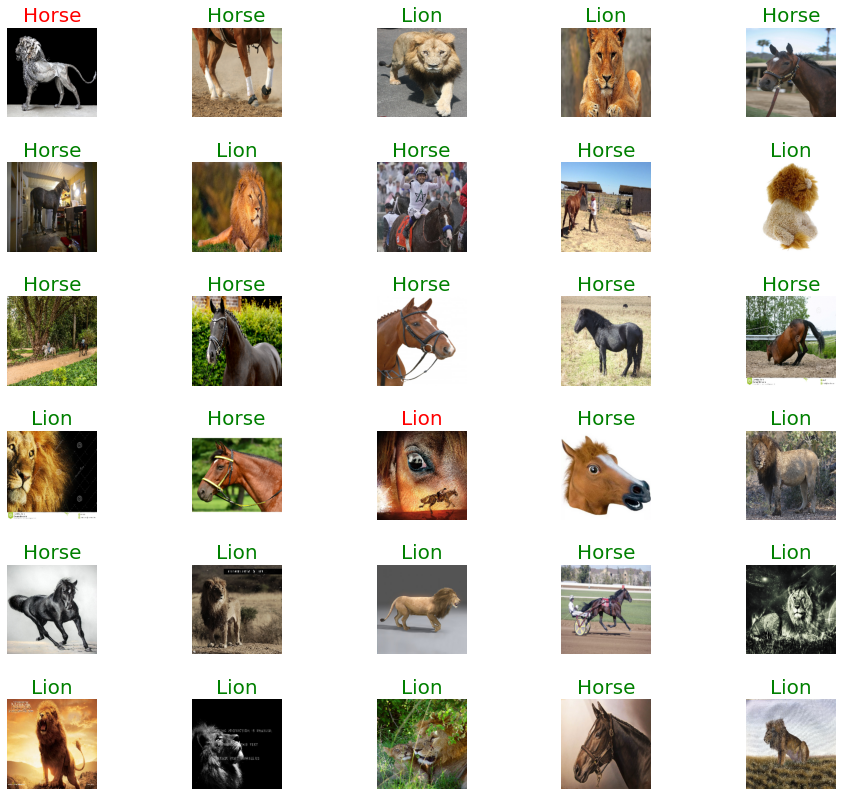

In [26]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color, fontdict={'fontsize': 20})
    plt.axis('off')